In [2]:
# 必要ライブラリ・コマンドの導入
!pip install torch torchvision torchao
!pip install torchtune
w = !apt install tree
print(w[-2])

tree is already the newest version (2.0.2-1).


In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm
from turtle import shape

# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import models


# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**共通関数の読み込み**

In [24]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, device, history):

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = list(input.to(device) for input in inputs)
            new_labels = []
            for labels_t in labels:
              keys = []
              boxes = []
              for label in labels_t:
                keys.append(label["labels"])
                boxes.append(label["boxes"])
              new_label = {"labels": tensor(np.array(keys)).to(device), "boxes": tensor(np.array(boxes)).to(device)}
              del keys
              del boxes
              new_labels.append(new_label)
            labels = new_labels
            del new_labels

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs, labels)

            # 損失計算
            loss = sum(loss for loss in outputs.values())
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 損失と精度の計算
            avg_train_loss = train_loss / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f}')
        item = np.array([epoch+1, avg_train_loss])
        history = np.vstack((history, item))
    return history

# 学習ログ解析

def evaluate_history(history):
    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='training')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve (loss)')
    plt.legend()
    plt.show()

# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mikoajkoek/traffic-road-object-detection-polish-12k")

print("Path to dataset files:", path)

Resuming download from 113246208 bytes (10688054525 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/mikoajkoek/traffic-road-object-detection-polish-12k?dataset_version_number=4 (113246208/10801300733) bytes left.


100%|██████████| 10.1G/10.1G [07:49<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mikoajkoek/traffic-road-object-detection-polish-12k/versions/4


In [6]:
!mv /root/.cache/kagglehub/datasets/mikoajkoek/traffic-road-object-detection-polish-12k/versions/4 ./traffic-road-object-detection-polish-12k

### アノテーションデータ読み込み

In [7]:
classes = ["green_light", "red_light"]

In [8]:
from PIL import Image
import json
import os

# データがあるディレクトリ
DATA_DIR = 'traffic-road-object-detection-polish-12k/road_detection/road_detection'

def make_file_list(dir, phase):
  file = []
  file_names = os.listdir(dir+f'/{phase}'+'/images')
  file_names.sort()
  for file_name in file_names:
    file.append(dir+f'/{phase}'+'/images/'+file_name)
  return file

def yolo_to_coco(label, box, image_size):
  label = label
  w = round(box[2]*image_size[1])
  h = round(box[3]*image_size[0])
  x1 = round(box[0]*image_size[1]-w/2)
  y1 = round(box[1]*image_size[0]-h/2)
  x2 = round(box[0]*image_size[1]+w/2)
  y2 = round(box[1]*image_size[0]+h/2)
  return {"labels":label,"boxes": [x1, y1, x2, y2]}


def make_anno_list(dir, phase):
  annotation_list = []
  anno = os.listdir(dir+f'/{phase}'+'/labels')
  anno.sort()
  for anno_in_a_image in anno:
    with open(dir+f'/{phase}'+'/labels/'+anno_in_a_image, 'r') as f:
      labels = []
      label = f.readlines()
      for l in label:
        l = list(map(float,l.split()))
        if l[0] == 2:
          l[0] = 1
          l = yolo_to_coco(l[0], l[1:], (531, 945))
          labels.append(l)
        elif l[0] == 7:
          l[0] = 2
          l = yolo_to_coco(l[0], l[1:], (531, 945))
          labels.append(l)
      annotation_list.append(labels)
  return annotation_list

def clean_dataset(file, anno):
  #検出したいオブジェクトが含まれない画像を除外
  n = len(anno)
  i=0
  while i<n:
    if len(anno[i]) == 0:
      del file[i]
      del anno[i]
      i -= 1
      n -= 1
    i += 1
  return file, anno

file = make_file_list(DATA_DIR, 'train')
anno = make_anno_list(DATA_DIR, 'train')
file, anno = clean_dataset(file, anno)

In [9]:
# シーン毎に学習用と評価用データに分ける
train_X, train_Y = file, anno

In [10]:
file = make_file_list(DATA_DIR, 'test')
anno = make_anno_list(DATA_DIR, 'test')
file, anno = clean_dataset(file, anno)

In [11]:
test_X, test_Y = file, anno

In [12]:
# データセットをクラスで定義する
class MyDataset(Dataset):
    def __init__(self, X, y, valid=False):
        # 初期化 Xはファイル名のリスト、yはネコかイヌかのリスト
        self.X = X
        self.y = y
        if not valid:
            trans = [
                # 画像のリサイズなどの前処理を追加する
                transforms.Resize((531, 945)), #リサイズ
                transforms.ToTensor(), #テンソル化
                transforms.Normalize(0.5, 0.5), #正規化
            ]
        else: # 評価時にはDAを含まないtransoformを作る
            trans = [
                # 画像のリサイズなどの前処理&データ拡張を追加する
                transforms.Resize((531, 945)),
                transforms.ToTensor(),
                transforms.Normalize(0.5, 0.5)
            ]
        self.trans = transforms.Compose(trans)

    def __len__(self):
        # データセットの長さを返す
        return len(self.X)

    def __getitem__(self, pos):
        # posの場所にあるデータを返す
        f = os.path.join(self.X[pos]) # ファイルパス
        X = Image.open(f).convert('RGB') # ファイルを読み込む
        X = self.trans(X) # DAしてtensorにする
        y = self.y[pos]
        return X, y

In [13]:
# 訓練用
from operator import truediv
from pickle import TRUE

# 学習用
train_data = MyDataset(train_X, train_Y)

# 検証用
test_data = MyDataset(test_X, test_Y, True)

In [14]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 3605件
検証データ: 205件


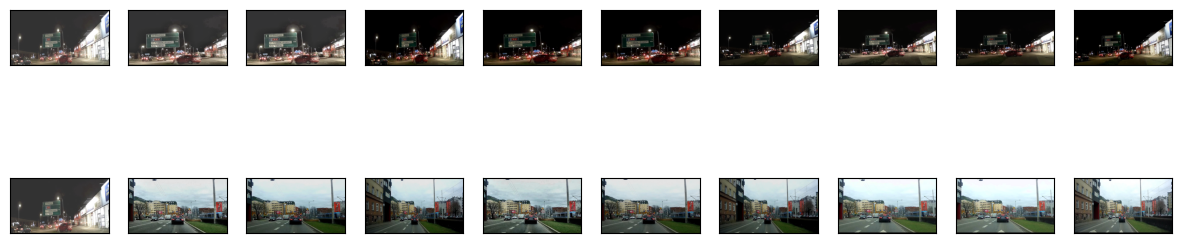

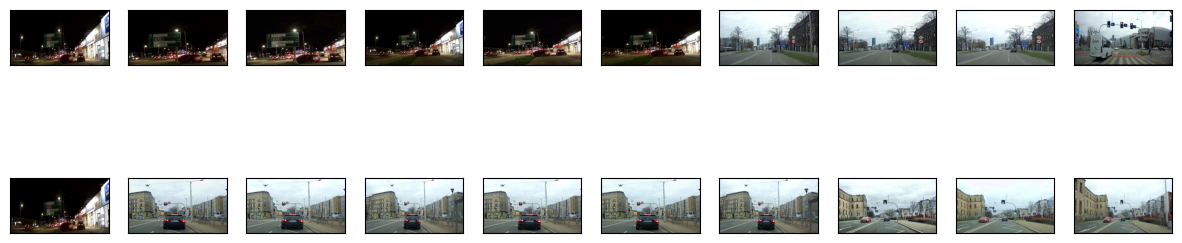

In [15]:
# 学習データと訓練データの最初の10個と最後の10個を表示

def show_head_and_tail(data):
    plt.figure(figsize=(15, 4))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        image, label = data[i] # dataを前から読み出す
        img = (np.moveaxis(image.numpy(), 0, -1)+1)/2# 軸の修正 & 値の範囲修正
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, 10, i + 11)
        image, label = data[-i]# dataを後ろから読み出す
        img = (np.moveaxis(image.numpy(), 0, -1)+1)/2# 軸の修正 & 値の範囲修正
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

show_head_and_tail(train_data)
show_head_and_tail(test_data)


[{'labels': 2, 'boxes': [160, 199, 188, 245]}, {'labels': 2, 'boxes': [267, 161, 308, 218]}, {'labels': 2, 'boxes': [428, 123, 477, 188]}]


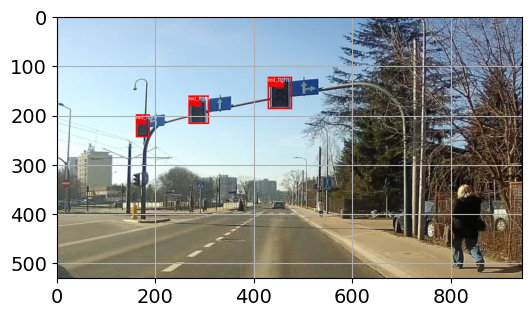

In [16]:
def show_annotation(data, i):
    import PIL
    import PIL.ImageDraw as ImageDraw
    import PIL.ImageFont as ImageFont
    image, labels = data[i] # dataを前から読み出す
    img = (np.moveaxis(image.numpy(), 0, -1)+1)/2# 軸の修正 & 値の範囲修正
    img = PIL.Image.fromarray((img*255).astype(np.uint8))
    draw = ImageDraw.Draw(img)

    for label in labels:
        l = label["labels"]
        box = label["boxes"]
        l = classes[int(l)-1]
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        # ラベルの表示
        draw.rectangle([box[0], box[1], box[0]+20, box[1]+20], fill="red")
        draw.text((box[0], box[1]), l, fill='white')

    plt.imshow(img)
    print(labels)

show_annotation(train_data, 2000)

## STEP3 ミニバッチ作成

In [17]:
# データローダー定義

batch_size = 25

def my_collate_fn(batch):
    # datasetの出力が
    # [image, target] = dataset[batch_idx]
    # の場合.
    images = []
    targets = []
    for sample in batch:
      image, target = sample
      images.append(image)
      targets.append(target)
    images = torch.stack(images, dim=0)
    return [images, targets]

def collate_fn(batch):
    return tuple(zip(*batch))

# 訓練用
train_loader = DataLoader(
    train_data, batch_size = batch_size,
    shuffle = True,
    collate_fn = collate_fn)

# 検証用
test_loader = DataLoader(
    test_data, batch_size = batch_size,
    shuffle = False,
    collate_fn = collate_fn)


## STEP4 モデル定義

In [18]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 学習済みモデルの読み込み
net = fasterrcnn_resnet50_fpn(weights = "COCO_V1", weights_backbone='DEFAULT')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 217MB/s]


In [19]:
#転移学習の設定
for param in net.parameters():
    param.requires_grad = False

torch_seed(123)

net.roi_heads.box_predictor = FastRCNNPredictor(net.roi_heads.box_predictor.cls_score.in_features, 3)


# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.roi_heads.box_predictor.parameters(), lr=lr, momentum=0.9)


## STEP5 学習

In [22]:
# historyファイルも同時に初期化する
history = np.zeros((0, 2))

# 学習
num_epochs = 30
history = fit(net, optimizer, criterion, num_epochs,
          train_loader, device, history)

  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [1/30], loss: 0.01259


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [2/30], loss: 0.01230


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [3/30], loss: 0.01212


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [4/30], loss: 0.01195


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [5/30], loss: 0.01182


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [6/30], loss: 0.01182


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [7/30], loss: 0.01164


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [8/30], loss: 0.01152


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [9/30], loss: 0.01149


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [10/30], loss: 0.01144


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [11/30], loss: 0.01137


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [12/30], loss: 0.01130


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [13/30], loss: 0.01128


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [14/30], loss: 0.01127


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [15/30], loss: 0.01129


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [16/30], loss: 0.01123


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [17/30], loss: 0.01114


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [18/30], loss: 0.01112


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [19/30], loss: 0.01110


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [20/30], loss: 0.01112


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [21/30], loss: 0.01110


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [22/30], loss: 0.01103


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [23/30], loss: 0.01112


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [24/30], loss: 0.01103


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [25/30], loss: 0.01102


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [26/30], loss: 0.01096


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [27/30], loss: 0.01097


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [28/30], loss: 0.01094


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [29/30], loss: 0.01093


  0%|          | 0/145 [00:00<?, ?it/s]

Epoch [30/30], loss: 0.01095


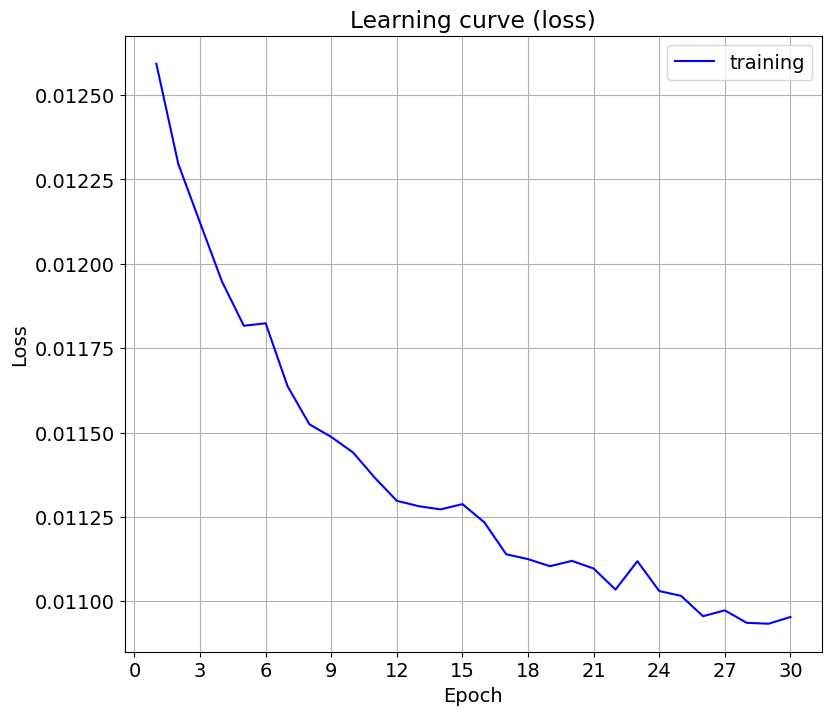

In [25]:
# 結果確認
evaluate_history(history)

**モデルの保存**

In [26]:
# エラー防止のため一旦CPUにモデルを移動
net.cpu()

# パラメータ保存
netparam_path =  "net.prm"
torch.save(net.state_dict(), netparam_path)

[{'labels': 1, 'boxes': [183, 112, 245, 176]}, {'labels': 2, 'boxes': [411, 121, 470, 186]}, {'labels': 2, 'boxes': [588, 129, 641, 195]}]


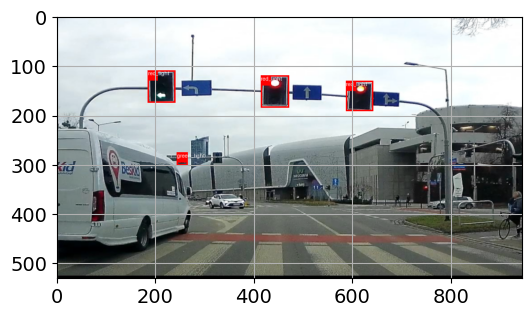

In [58]:
def show_annotation_test(data, net, i):
    import PIL
    import PIL.ImageDraw as ImageDraw
    import PIL.ImageFont as ImageFont
    image, labels = data[i] # dataを前から読み出す

    net.to(device)
    net.eval()
    image = image.to(device)
    # predict
    outputs = net([image])
    outputs = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in outputs]
    outputs = outputs[0]

    image = image.cpu()
    img = (np.moveaxis(image.numpy(), 0, -1)+1)/2# 軸の修正 & 値の範囲修正
    img = PIL.Image.fromarray((img*255).astype(np.uint8))
    draw = ImageDraw.Draw(img)

    for i in range(len(outputs["labels"])):
      if outputs["scores"][i] > 0.5:
        l = outputs["labels"][i]
        box = outputs["boxes"][i]
        l = classes[int(l)-1]
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        # ラベルの表示
        draw.rectangle([box[0], box[1], box[0]+20, box[1]+20], fill="red")
        draw.text((box[0], box[1]), l, fill='white')

    plt.imshow(img)
    print(labels)

show_annotation_test(test_data, net, 10)